# Try a Deep Convolutional Generative Adversarial Network on DDSM Dataset

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from PIL import Image

import itertools


In [2]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Hyperparameters

In [3]:
# Root directory for dataset
dataroot = '../bc_images/'
dataroot2 = '../bc_masks/'

# Number of workers for dataloader
num_workers = 16

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [4]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load the data & create a DataLoader

In [5]:
class DDSM(torch.utils.data.Dataset):             # Notice that masks are in PNG form and mammograms in JPG
    def __init__(self, root1, root2, transform, transform2):
        self.root1 = root1
        self.root2 = root2
        
        imagedir =os.listdir(root1)
    
                
        maskdir =os.listdir(root2)
        #maskdir.remove('.ipynb_checkpoints')
        mask_dir = sorted(maskdir)
        
        img_list = sorted(imagedir)
                    
        self.mask_list = mask_dir
        self.new_img_list = img_list
                    
        self.transform = transform
        self.transform2 = transform2
        
          
        

    def __len__(self):
        
        return len(self.new_img_list)

    def __getitem__(self, idx):
        image_name = self.new_img_list[idx]

        image = Image.open(os.path.join(self.root1, image_name)).convert("L")
        image = self.transform(image)
        
        mask_name = self.mask_list[idx]
        mask = Image.open(os.path.join(self.root2,mask_name)).convert("L")
    
        mask = self.transform2(mask) 
        
        return image, mask
    

transform = transforms.Compose([
                
                transforms.Resize([64,64]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])])

transform2 = transforms.Compose([
             
                transforms.Resize([64,64]),
                transforms.ToTensor()])

BC_dataset = DDSM(dataroot, dataroot2,  transform=transform, transform2 = transform2)



BC_loader = torch.utils.data.DataLoader(
        BC_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

#  Weight initialization for both Generator and Discriminator

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Class Adversarial AutoEncoder Generator

In [7]:
# Generator Code

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        #input 1x64x64
        self.conv1 = nn.Conv2d(nc, ngf, 3, 1, 1, bias=False) # one channel for the image one for the mask
        self.bn1 = nn.BatchNorm2d(ngf)   
        #first layer ngf x 64 x 64
        self.conv2 = nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False)  # second layer will be concatenated (remember x and y)
        self.bn2 = nn.BatchNorm2d(ngf * 2)
        #second layer ngf*2 x 32 x 32
        self.conv3 = nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        #third layer ngf*4 x 16 x 16
        self.conv4 =  nn.Conv2d( ngf * 4, ngf * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf * 8)
        #forth layer ngf*8 x 8 x 8
        self.conv5 =  nn.Conv2d( ngf * 8, ngf * 16, 4, 2, 1, bias=False)
        
        #fifth layer ngf*16 x 4 x 4
            
    def forward(self, input):
        x = F.leaky_relu(self.bn1(self.conv1(input)), 0.2)
        #print('1: ', x.shape)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        #print('2: ', x.shape)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        #print('3: ', x.shape)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        #print('4: ', x.shape)
        x = torch.tanh(self.conv5(x))
        #print('5: ', x.shape)
        return x
            
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.dec1 = nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        #1st layer ngf* 8 x 8 x 8
        self.dec2 = nn.ConvTranspose2d(ngf*8, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)
        #2nd layer ngf*4 x 16 x 16
        self.dec3 = nn.ConvTranspose2d(ngf*4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)
        #3rd ngf*2 x 32 x 32
        self.dec4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        #4th layer ngf x 64 x 64
        self.dec5 = nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False)
        #5th layer 1 x 64 x 64
     
    def forward(self, input):
        x = F.relu(self.bn1(self.dec1(input)))
        #print('1: ', x.shape)
        x = F.relu(self.bn2(self.dec2(x)))
        #print('2: ', x.shape)
        x = F.relu(self.bn3(self.dec3(x)))
        #print('3: ', x.shape)
        x = F.relu(self.bn4(self.dec4(x)))
        #print('4: ', x.shape)
        x = torch.tanh(self.dec5(x))
        #print('5: ', x.shape)

        return x

In [8]:
encoder = Encoder()
encoder = encoder.to(device)


encoder.apply(weights_init)

# Handle multi-gpu if desired
if (device.type == 'cuda') and ngpu > 1:
#     encoder = nn.DataParallel(encoder, list(range(ngpu))) ### ti einai auto pou kaneis edw de katalava..!
    encoder = nn.DataParallel(encoder)
    
print(encoder.module)

Encoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [9]:
# Create the decoder
decoder = Decoder()
decoder = decoder.to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
decoder.apply(weights_init)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    decoder = nn.DataParallel(decoder)


# Print the model
print(decoder.module)

Decoder(
  (dec1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec5): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


# Class Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64   
            nn.Conv2d(nc, ndf , 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf ) x 32 x 32
            nn.Conv2d(ndf , ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 8) x 4 x 4
            nn.Conv2d(ndf *8 , 1, 4, 1, 0, bias=False),  
            nn.Sigmoid()
            # prob (0,1)
        )

    def forward(self, input):
        return self.main(input)

    
    
    


In [11]:
# Create the Discriminator
netD = Discriminator()
netD = netD.to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD) 

# Print the model
print(netD.module)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()


In [13]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(beta1, 0.999))

# Load and do evaluation on the trained on 40 epochs model

In [14]:
path= '../saved_models/model-DCGAN-BC-AdversarialEncDec-patch-MaskInfilling-DifferentSizesBasedOnMasks/'

In [15]:
encoder.load_state_dict(torch.load(path + 'encoder-patch-AE-40e.pth'))
decoder.load_state_dict(torch.load(path + 'decoder-patch-AE-40e.pth'))

netD.load_state_dict(torch.load(path + 'netD-patch-AE.pth'))

In [16]:
encoder.eval()

DataParallel(
  (module): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [17]:
decoder.eval()

DataParallel(
  (module): Decoder(
    (dec1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec5): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

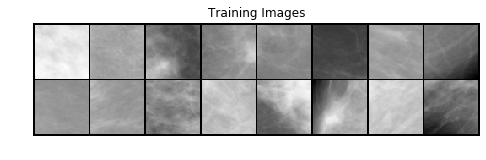

In [18]:
# Plot some training images
real_batch = next(iter(BC_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))

In [19]:
mask_patch = real_batch[1]
np.place(mask_patch.numpy(),mask_patch.numpy()>0, [1])


In [20]:
print(torch.min(mask_patch))
print(torch.max(mask_patch))

tensor(0.)
tensor(1.)


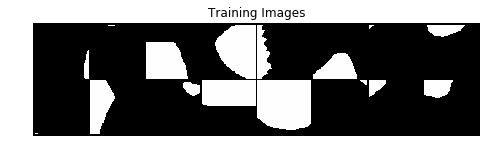

In [21]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(mask_patch.to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
def createpatch(mydata, masks, batch_size):
    real = Variable(mydata.data.clone())
    mask = Variable(masks.data.clone())
    realdata = real[:batch_size]
    maskdata = mask[:batch_size]
    
    ## find the mask location
    maskpos = np.where(maskdata==1)
    
    #create index file
    indices = np.empty((maskpos[0].shape[0], len(maskpos)))
    for i in range(maskpos[0].shape[0]):
    
        indices[i] = np.array((maskpos[0][i],maskpos[1][i],maskpos[2][i], maskpos[3][i]))
    
    
    
    #Get the min max index for rows and columns of all images and obtain the biggest sizes
    #print(indices[1])
    
    
    # transform real images to have a noise input
    
    for index in indices:
        realdata[int(index[0])][int(index[1])][int(index[2])][int(index[3])] = np.random.uniform(-1,1)
    
    count = 0
    rowlist = []
    columnlist = []
    size_list = []
    index_list = []
    new_batch = np.append(maskpos[0],64) # add an extra  random number to make the for loop work for all 64 batches
    new_rows = np.append(maskpos[2],64)
    new_columns = np.append(maskpos[3],64)
    for batch, row, column in zip (new_batch, new_rows, new_columns):
        
        
        if batch == count:
            rowlist.append(row)
            #print(min(rowlist))
            columnlist.append(column)
            count = count + 0
            
    
                
        
        else:     # do calculations and empty the list to create new with the new batch
            #print('Rows', max(rowlist), min(rowlist))
            #print('Columns', max(columnlist)-min(columnlist))
            if all ([len(rowlist) != 0, len(columnlist)!=0]):
                index_list.append([min(rowlist), max(rowlist),min(columnlist), max(columnlist)])
                size_list.append([max(rowlist)-min(rowlist),max(columnlist)-min(columnlist)])

                rowlist.clear()
                columnlist.clear()
                count = count + 1
           
            else:
                index_list.append([0,0,0,0])  # For those mask images that surprisingly stayed out of all-black filtering
                size_list.append([0,0])
                count = count + 1
                pass
                
            
    realdata2 = np.copy(realdata)
    
    for i, (index) in enumerate(index_list): #zip does not work due to float and int in the same call function
        for j in range(index[0],index[1]+1):
            for k in range(index[2],index[3]+1):
                realdata2[i][:, j, k] = np.random.uniform(-1,1)
        
    realdata2 = torch.from_numpy(realdata2)
     
    #print(len(size_list))
    
  #  print('Get the largest box size: ', max(size_list))    # Tha doesn't work properly
    
    return realdata, size_list, index_list, realdata2

In [23]:
imgs, mylist, indexlist,test_noise = createpatch(real_batch[0], mask_patch, batch_size)
test_noise = test_noise.to(device)

In [24]:
encoded_imgs = encoder(test_noise)
fakes = decoder(encoded_imgs)


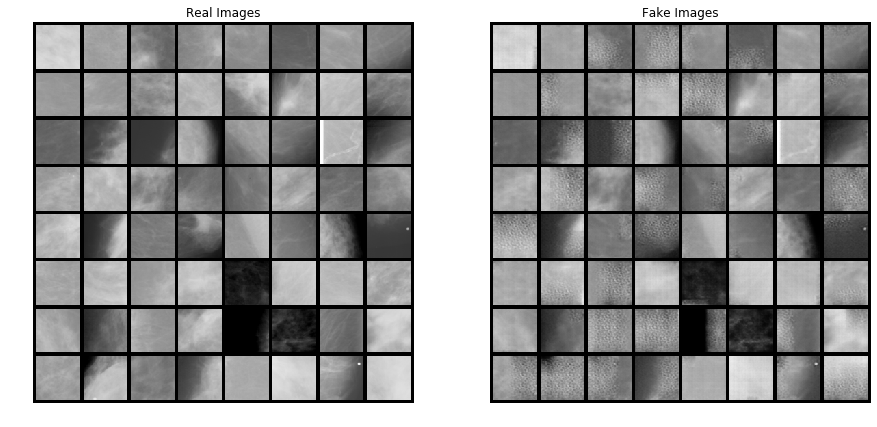

In [25]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fakes.detach().to(device), padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

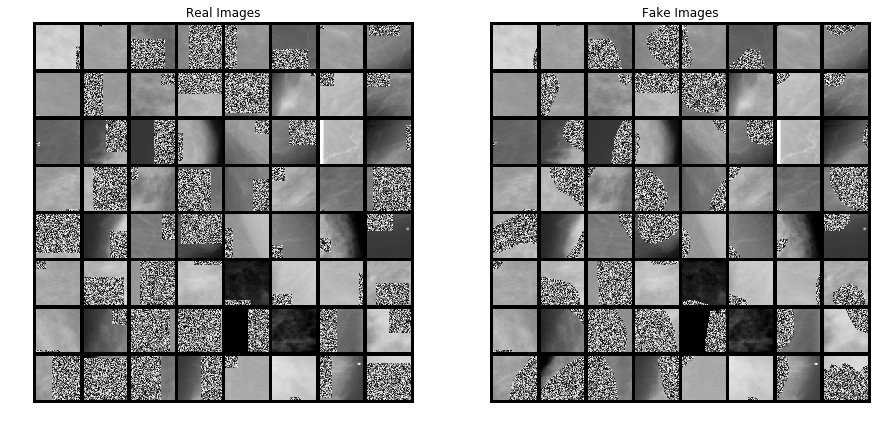

In [26]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_noise.to(device), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(imgs.to(device), padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [57]:
#for i in range(fakes.shape[0]):

    #vutils.save_image(fakes[i,:,:,:], os.path.join('./generated_images/','{}.png'.format(i)), padding=5, normalize=True)
    

In [58]:
#for i in range(test_batch[0].shape[0]):

    #vutils.save_image(test_batch[0][i,:,:,:], os.path.join('./real_images/','{}.png'.format(i)), padding=5, normalize=True)
    

In [27]:
cou = 0
for j,data in enumerate(test_loader,0):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        for i in range(b_size):
            try:
      
                vutils.save_image(real_cpu[i,:,:,:], os.path.join('./real_images/','{}.png'.format(cou)), padding=5, normalize=True)
                cou = cou + 1


            except:
                print('The last batch is smaller so I ignored the error')
                pass


            
# Ignore the error, it is because the last batch is smaller than 64 images

In [28]:
count = 0 
with torch.no_grad():
    for j,data in enumerate(test_loader,0):

    
        
        # Format batch
        
        
        try:

            noise = makelesion(data[0], batch_size)
            noise = noise.to(device)
            b_size = noise.size(0)

            encoded_imgs = encoder(noise)
            fake = decoder(encoded_imgs)

            for i in range(b_size):

                vutils.save_image(fake[i,:,:,:], os.path.join('./generated_images/','{}.png'.format(count)), padding=5, normalize=True)
                count = count + 1
                
        except:
            print('The last batch is smaller so I ignored the error')
            pass

The last batch is smaller so I ignored the error
